In [19]:
import os,sys,time
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

In [20]:
def load_tif_img(filename:str):
    with Image.open(filename) as img:
        img_data = np.array(img,dtype=np.float32)
        print(f'shape of the read img={np.shape(img_data)}')
        # save raw image info
    return img_data

def get_I_range(tif_data:np.array([])):
    """get the range of pixel intensity of the image

    Args:
        tif_data (np.array): img array
    Returns:
        (I_min:int,I_max:int):min, aver, median, max, percentile80 intensity of the img array
    """
    w, h = np.shape(tif_data)
    if w > 0 and h > 0:
        return (int(np.min(tif_data)),int(np.average(tif_data)),
                int(np.median(tif_data)),int(np.max(tif_data)),int(np.percentile(tif_data,80)))

def plot_tif_img(ax:plt.Axes,img_data:np.array([]),params:dict):
    """plot the image

    Args:
        img_data (np.array): img array
        params (dict): params dict
        ax (plt.Axes): axes
    """
    if np.shape(img_data) != ():
        I_min,I_aver,I_median,I_max,I_80per=get_I_range(img_data)
        I_80per+=I_median-I_min # vmin=1500,vmax=3600
        im = ax.imshow(img_data, cmap=colormap.rainbow,vmin=I_min,vmax=I_80per)
        #ax.set_title(f"I_min:{I_min:.2f},I_aver:{I_aver:.2f},I_median:{I_median:.2f}")
        for key,value in params.items():
            #text=ax.text(x=100,y=125,s=f"{key}:{value}",color='white',fontsize=20,va='bottom',ha='left')
            text=ax.set_title(f"{key}:{value}",color='red',loc='center')
        return im,text

In [51]:
# 构造低通滤波器
low_pass_filter = np.array([
   [1, 1, 1],
   [1, 1, 1],
   [1, 1, 1]
])

# 构造高通滤波器
high_pass_filter = np.array([
   [0, -1, 0],
   [-1, 4, -1],
   [0, -1, 0]
])
# load image
#tif_file=os.path.abspath('.\\tif_img\\01-LV_TiO2@440.3eV_Gap29__Slit1-1000x1500_slit2-100_CCDY-3341_CCDZ-1000_GrateRx-6742_T3600s.tif')
tif_file=os.path.abspath(r'L:\RXES_CCD2048\20240422\alpha-Fe2O3\Mapping\M0_Energy-536.00_536.00eV_slit2_200_Alpha_Fe2O3_20240423_0713_dt300s_169.tif')
tif_data=load_tif_img(tif_file)

shape of the read img=(2052, 2048)


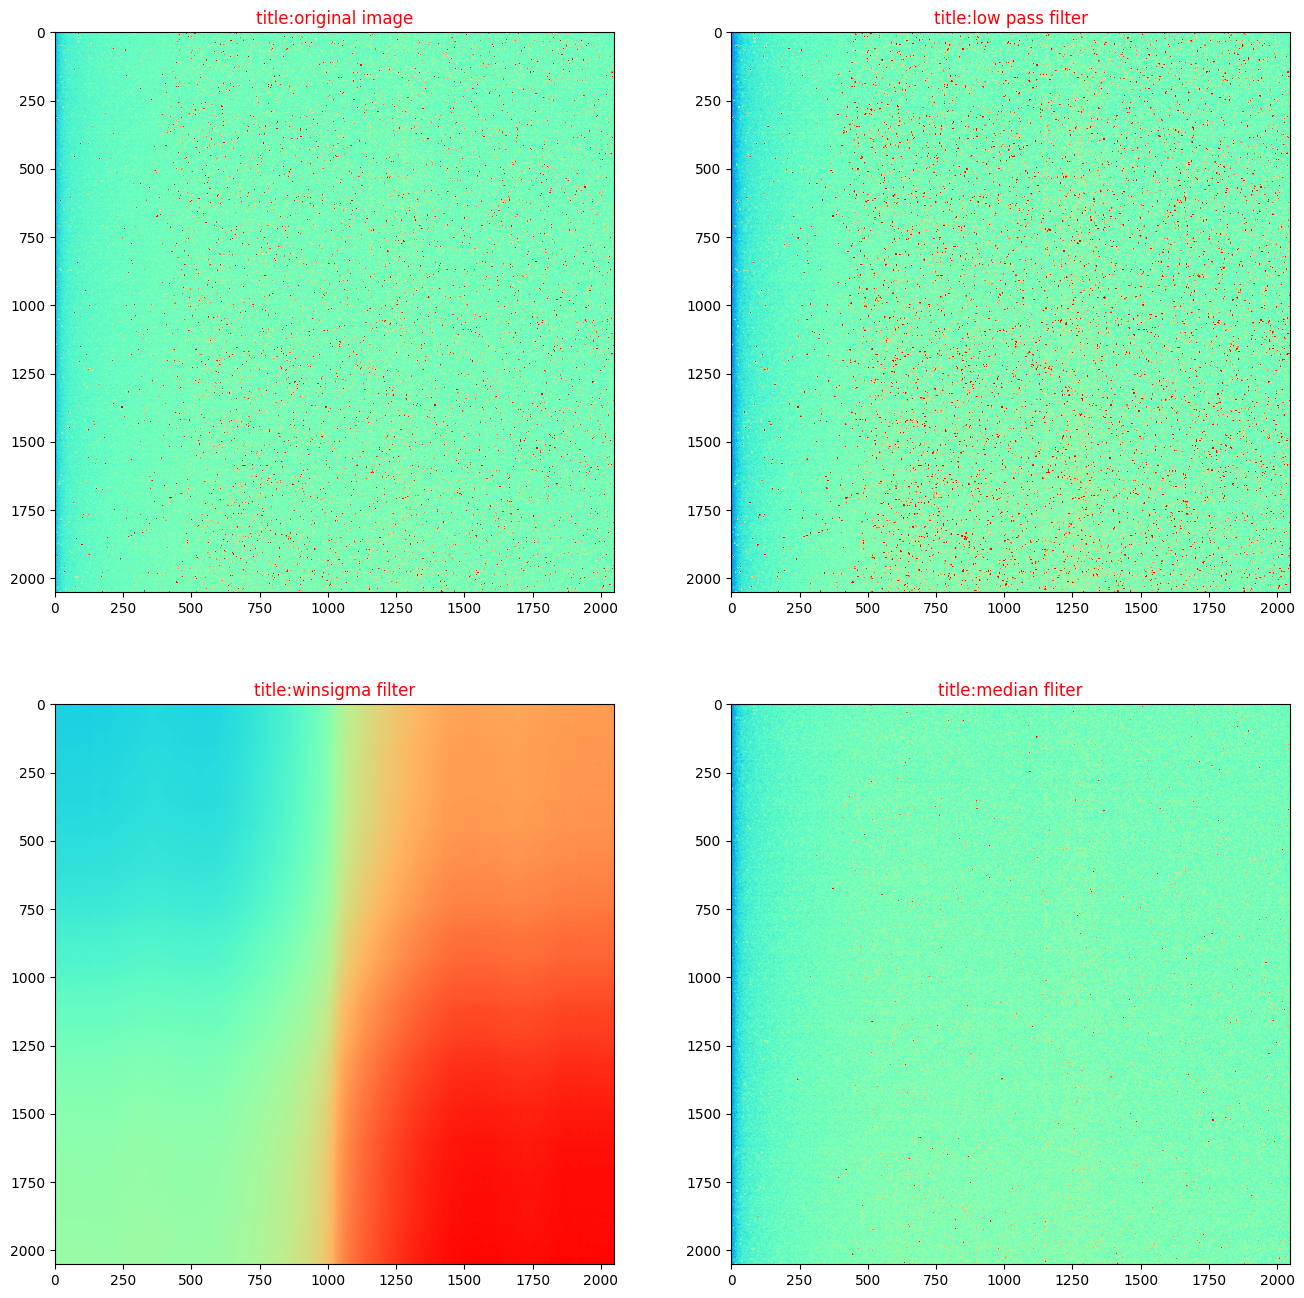

In [22]:
# 使用低通滤波器
low_pass_img = cv2.filter2D(tif_data, -1, low_pass_filter)

# 使用高通滤波器
high_pass_img = cv2.filter2D(tif_data, -1, high_pass_filter) #not working

# median fliter
median_img=cv2.medianBlur(tif_data, 3)

# 使用非局部均值滤波器
# 构造维纳滤波器
alpha = 0.5
beta = 0.1
winaverage_filter = np.array([
  [(1 - alpha - beta) / 255 for i in range(tif_data.shape[1])]
  for j in range(tif_data.shape[0])
])
winsigma_filter = np.array([
  [beta / (tif_data.shape[1] * 255) for i in range(tif_data.shape[1])]
  for j in range(tif_data.shape[0])
])

# 使用维纳滤波器
winaverage_img = cv2.filter2D(tif_data, -1, winaverage_filter)
winsigma_img = cv2.filter2D(tif_data, -1, winsigma_filter)


fig = plt.figure(figsize=(16, 16))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)
plot_tif_img(ax1, tif_data, params={'title': 'original image'})
plot_tif_img(ax2, low_pass_img, params={'title': 'low pass filter'})
plot_tif_img(ax3, winsigma_img, params={'title': 'winsigma filter'})
plot_tif_img(ax4, median_img, params={'title': 'median fliter'})
plt.show()

In [23]:
import cv2
import numpy as np

# 构造低通滤波器
low_pass_filter = np.array([
   [1, 1, 1],
   [1, 1, 1],
   [1, 1, 1]
])

# 构造高通滤波器
high_pass_filter = np.array([
   [0, -1, 0],
   [-1, 4, -1],
   [0, -1, 0]
])

# 读取图像
img = cv2.imread('../img/018.png')

# 将图像转换为灰度图像
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 使用低通滤波器
low_pass_img = cv2.filter2D(gray_img, -1, low_pass_filter)

# 使用高通滤波器
high_pass_img = cv2.filter2D(gray_img, -1, high_pass_filter)

# 显示原始图像和滤波后的图像
cv2.imshow('Original Image', gray_img)
cv2.imshow('Low Pass Image', low_pass_img)
cv2.imshow('High Pass Image', high_pass_img)

cv2.waitKey(0)
cv2.destroyAllWindows()

In [24]:
def Read_Tif_XMP(tif_file:str):
    """read tif image by tifffile

    Args:
        tif_file (str): _description_
    Returns:
        tif_data (np.array),img_Description(list(dicts))
    """
    tif_data=np.array([])
    if os.path.isfile(tif_file) and tif_file.endswith('.tif'):
        img = Image.open(tif_file)
        tif_data = np.array(img,dtype=np.float32)
        xmp_all=img.getxmp()['xmpmeta']
        xmptk=xmp_all['xmptk']
        print(f'acquire equipment name :{xmptk}')
        xmp_RDF=xmp_all['RDF']
        img_Description_dictlist=xmp_all['RDF']['Description']
    return tif_data,img_Description_dictlist


In [116]:
from tifffile import tifffile,TiffFile
from PIL import Image
import ast
print(Image.open(tif_file).getexif()[270])
if meta_data:=TiffFile(tif_file).shaped_metadata:
    meta_dict=meta_data[0]
meta_dict['samplename']

{"username": "Limin", "samplename": "Alpha_Fe2O3", "timestamp": "2024-04-23_071339", "beamline_info": "BL20U2_SSRF", "program_info": "QM_REXS_limin", "camera_model": "GE 2048 2048 BI AIMO", "exposureTime-s": 300.0, "Tem_Sensor_Backside": [-60, 30], "readout_speed": "500 kHz", "correctBias": true, "energy(eV)": "535.9989", "energy_edge": "O_K", "mapping_edge": "O_LV22d1", "Slit2_size": 200, "SAM_X": -2501.25, "SAM_Y": 2685.0, "SAM_Z": 3000.0, "SAM_theta": 8.5, "Energy": 535.9989, "DET_2theta": -10.0, "SAM_Chi": 0.0, "SAM_Phi": 0.0, "TEY_I": 1.5549e-09, "Au_I": 9.316459e-11, "PD_I": 0, "Grate_X": 1728.0, "Grate_R-X": -6558.003, "RXES_CCD_Y": -58083.0, "RXES_CCD_Z": 18020.0, "RXES_CCD_R-X": 35999.4, "img_data_hash": "40f964b2d8c6735dfbdbeed1ce90b3c3170e55c9cced959893179a6546beabc7", "shape": [2052, 2048]}


'Alpha_Fe2O3'

In [ ]:
from tifffile import tifffile,TiffFile
def Read_ccd_Tif_metadata(tif_file:str):
    meta_dict={}
    if meta_data:=TiffFile(tif_file).shaped_metadata:
        meta_dict=meta_data[0]
    return meta_dict


In [104]:
im=Image.open(tif_file)
exif = im.getexif()
# for k, v in exif.items():
#   print("Tag", k, "Value", v)  # Tag 274 Value 2
exif[270]
info_dict=ast.literal_eval(exif[270])


ValueError: malformed node or string on line 1: <ast.Name object at 0x0000021A94B8CA30>

In [101]:
str='{"username": "Limin", "samplename": "Alpha_Fe2O3","timestamp": "2024-04-23_071339", "beamline_info": "BL20U2_SSRF", "program_info": "QM_REXS_limin","camera_model": "GE 2048 2048 BI AIMO", "exposureTime-s": 300.0,"Tem_Sensor_Backside": [-60, 30], "readout_speed": "500 kHz","energy(eV)": "535.9989", "energy_edge": "O_K", "mapping_edge": "O_LV22d1", "Slit2_size": 200, "SAM_X": -2501.25, "SAM_Y": 2685.0, "SAM_Z": 3000.0, "SAM_theta": 8.5, "Energy": 535.9989, "DET_2theta": -10.0, "SAM_Chi": 0.0, "SAM_Phi": 0.0, "TEY_I": 1.5549e-09, "Au_I": 9.316459e-11, "PD_I": 0, "Grate_X": 1728.0, "Grate_R-X": -6558.003, "RXES_CCD_Y": -58083.0, "RXES_CCD_Z": 18020.0, "RXES_CCD_R-X": 35999.4, "img_data_hash": "40f964b2d8c6735dfbdbeed1ce90b3c3170e55c9cced959893179a6546beabc7", "shape": [2052, 2048]}'
ast.literal_eval(str)

{'username': 'Limin',
 'samplename': 'Alpha_Fe2O3',
 'timestamp': '2024-04-23_071339',
 'beamline_info': 'BL20U2_SSRF',
 'program_info': 'QM_REXS_limin',
 'camera_model': 'GE 2048 2048 BI AIMO',
 'exposureTime-s': 300.0,
 'Tem_Sensor_Backside': [-60, 30],
 'readout_speed': '500 kHz',
 'energy(eV)': '535.9989',
 'energy_edge': 'O_K',
 'mapping_edge': 'O_LV22d1',
 'Slit2_size': 200,
 'SAM_X': -2501.25,
 'SAM_Y': 2685.0,
 'SAM_Z': 3000.0,
 'SAM_theta': 8.5,
 'Energy': 535.9989,
 'DET_2theta': -10.0,
 'SAM_Chi': 0.0,
 'SAM_Phi': 0.0,
 'TEY_I': 1.5549e-09,
 'Au_I': 9.316459e-11,
 'PD_I': 0,
 'Grate_X': 1728.0,
 'Grate_R-X': -6558.003,
 'RXES_CCD_Y': -58083.0,
 'RXES_CCD_Z': 18020.0,
 'RXES_CCD_R-X': 35999.4,
 'img_data_hash': '40f964b2d8c6735dfbdbeed1ce90b3c3170e55c9cced959893179a6546beabc7',
 'shape': [2052, 2048]}